In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
#load data inflation
inflation = pd.read_csv('Data/CPIAUCNS.csv')

# create index multiplier
inflation['CPI_Multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']

# Keep only the year
inflation['DATE'] = inflation['DATE'].str[:4]

inflation.sort_values(by = 'DATE', ascending = False)

,DATE,CPIAUCNS,CPI_Multiplier
1317,2022,298.012,1.000000
1316,2022,296.808,1.004056
1315,2022,296.171,1.006216
1314,2022,296.276,1.005859
1313,2022,296.311,1.005741
...,...,...,...
8,1913,10.000,29.801200
9,1913,10.000,29.801200
10,1913,10.100,29.506139
11,1913,10.000,29.801200


In [12]:
mov=pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
mov.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
mov.head()

# mov.to_excel('mov.xlsx', index=False)

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Let's check how many missing values we have

In [13]:
mov.isnull().sum()

wiki_movie_ID             0
freebase_movie_ID         0
movie_name                0
movie_release_date     6902
movie_box_off_rev     73340
movie_runtime         20450
movie_languages           0
movie_countries           0
movie_genres              0
dtype: int64

In [14]:
len(mov)

81741

In [15]:
print("{:.2%} of the movies have a missing movie box offix revenue value".format(mov.isnull().sum()['movie_box_off_rev']/len(mov)))

89.72% of the movies have a missing movie box offix revenue value


In [16]:
movies_copy = mov
movies_copy.loc[62836, 'movie_release_date'] = '2010-12-02'   #solve a problem of date
movies_copy['movie_release_date'] = movies_copy['movie_release_date'].str[:4]   #only take the year
movies_copy.sort_values(by = 'movie_release_date', ascending = False).head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
64862,3139382,/m/08tyfg,Battle Angel,2016,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016,NaN,NaN,{},{},{}
51429,25813358,/m/0gmbk1g,Avatar 2,2015,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
8307,24179103,/m/0jwx0kc,"I, Robot 2",2015,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}"


Are the missing values well distributed over time ?

In [17]:
movies_with_bor = movies_copy[movies_copy.movie_box_off_rev.isnull()==False]
movies_with_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_release_date']].count()
movies_with_bor_gp_year

,movie_release_date
movie_release_date,
1897,1
1914,4
1915,1
1920,1
1921,3
...,...
2008,367
2009,363
2010,329


Text(0.5, 1.0, 'Number of values available per year for the feature "movie_box_off_rev"')

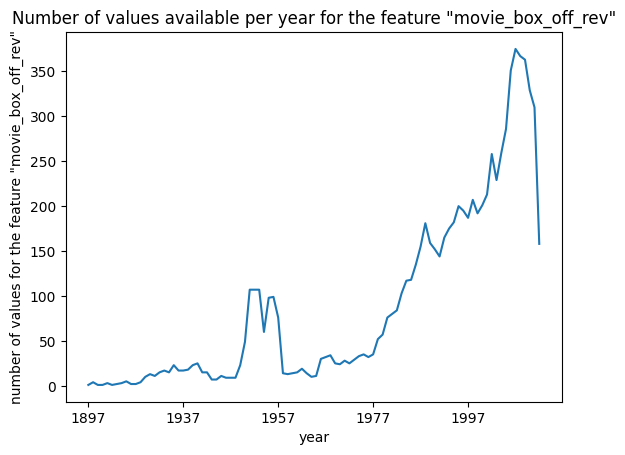

In [18]:
movies_with_bor_gp_year.plot(legend=False)
plt.ylabel('number of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Number of values available per year for the feature "movie_box_off_rev"')

In [19]:
movies_with_bor.sort_values(by = 'movie_release_date', ascending = False).head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
49857,28063569,/m/087wc7n,The Lorax,2012,346303939.0,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01zhp"": ""Computer Animation"", ""/m/04t36"":..."
28780,30270338,/m/0g54bw9,Joyful Noise,2012,30981384.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}"
78929,28882162,/m/0ddbjy4,Dredd,2012,36000000.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
56362,33918476,/m/0h1j5fv,Liberal Arts,2012,150210.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0556j8"": ""..."
78765,24732529,/m/08095xk,Upside Down,2012,5938940.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/0d060g"": ""Canada""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."


We do not have any information after 2012. It seems normal because the paper has been published in 2012

We can see that there are many missing values after 2000 but it could be due to the fact that there are in total more data during this period. The analysis of the ratio of missing values is then more interesting

In [20]:
movie_count_all_gp_year=movies_copy.groupby(movies_copy['movie_release_date'])[['movie_release_date']].count()
movie_count_all_gp_year['ratio_bor']=movies_with_bor_gp_year['movie_release_date']/movie_count_all_gp_year['movie_release_date']

Text(0.5, 1.0, 'Ratio of values available per year for the feature "movie_box_off_rev"')

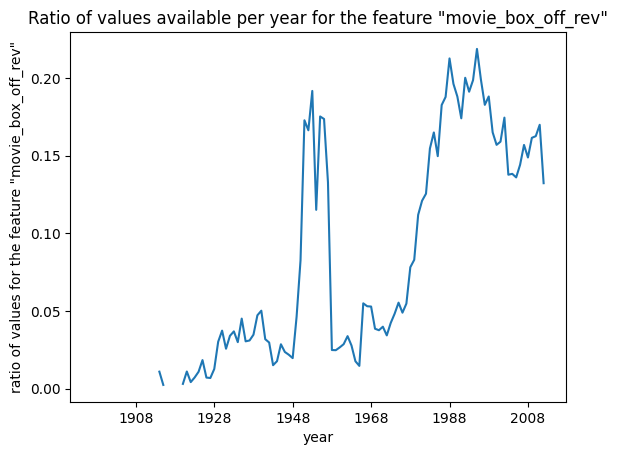

In [21]:
movie_count_all_gp_year['ratio_bor'].plot(legend=False)
plt.ylabel('ratio of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Ratio of values available per year for the feature "movie_box_off_rev"')

Let's check the evolution of the average revenue of box offices through time

In [22]:
movies_mean_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean()
movies_mean_bor_gp_year

,movie_box_off_rev
movie_release_date,
1897,1.000000e+05
1914,7.079320e+05
1915,5.000000e+07
1920,4.500000e+06
1921,2.633333e+06
...,...
2008,6.071359e+07
2009,6.835295e+07
2010,6.990730e+07


Text(0.5, 1.0, 'Evolution of the average box office revenue')

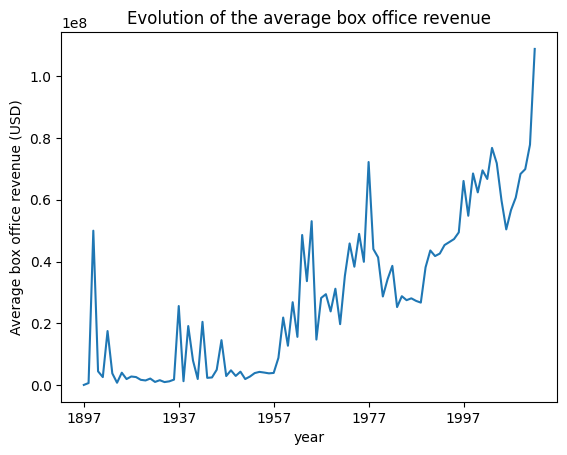

In [23]:
movies_mean_bor_gp_year.plot(legend=False)
plt.ylabel('Average box office revenue (USD)')
plt.xlabel('year')
plt.title('Evolution of the average box office revenue')

Even if these results are interesting, the amount of missing values is quite problematic. To evaluate the success of a movie, we can also look at the ratings of the movies. The data is not availeble in our dataset but we can use IMDb.

<AxesSubplot: xlabel='movie_release_date'>

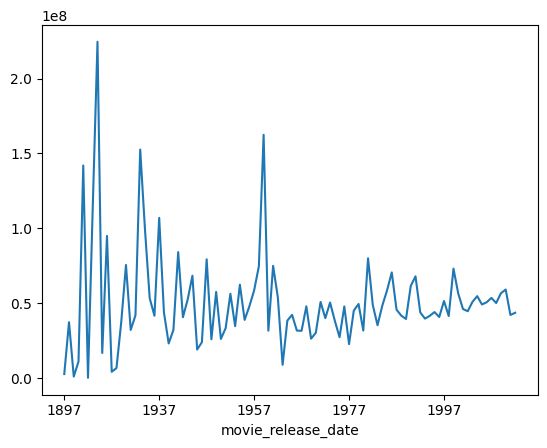

In [29]:
# Correcting with inflation
movies_with_corrected_bor = pd.merge(movies_with_bor, inflation, how = 'left', left_on = 'movie_release_date', right_on = 'DATE')
movies_with_corrected_bor['corrected_bo'] = movies_with_corrected_bor['movie_box_off_rev'].mul(movies_with_corrected_bor['CPI_Multiplier'])

movies_with_corrected_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean().plot(legend = False)

# IMDb dataset

In [30]:
imdb=pd.read_csv('Data/Imdb/processed_imdb_dataset.csv')
imdb

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,0,/m/03vyhn,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55271
1,1,/m/0crgdbh,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,2,/m/01mrr1,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,590
3,3,/m/03cfc81,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,4,/m/02qc0j7,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2160
...,...,...,...,...,...,...,...,...,...,...,...
45017,46784,/m/03m6zh4,tt0109922,movie,Gopi Kishan,Gopi Kishan,1994,161,"Action,Comedy,Drama",5.8,913
45018,46785,/m/06_vb43,tt0033660,movie,The Ghost Train,The Ghost Train,1941,85,"Comedy,Horror",6.2,1531
45019,46786,/m/0j7hxnt,tt1816585,tvMovie,Mermaids: The Body Found,Mermaids: The Body Found,2011,82,Sci-Fi,4.6,1656
45020,46787,/m/0g4pl34,tt1606259,movie,Knuckle,Knuckle,2011,97,"Biography,Documentary,Drama",6.8,3081


In [31]:
len(imdb)

45022

In [32]:
imdb_rating_gp_year=imdb.groupby(imdb['startYear'])[['averageRating']].mean()
imdb_rating_gp_year

,averageRating
startYear,
1888,7.300000
1889,5.000000
1890,5.200000
1891,4.966667
1892,6.050000
...,...
2011,6.092466
2012,6.130281
2013,6.163750


Text(0.5, 1.0, 'Evolution of movie ratings')

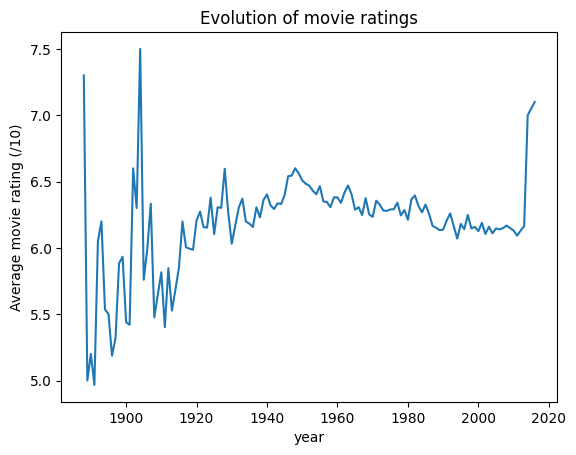

In [33]:
imdb_rating_gp_year.plot(legend=False)
plt.ylabel('Average movie rating (/10)')
plt.xlabel('year')
plt.title('Evolution of movie ratings')

In [34]:
#merge imdb et movie metadata

imdb.sort_values(by = 'startYear', ascending = False).head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
16661,17361,/m/0c03gcc,tt2267968,movie,Kung Fu Panda 3,Kung Fu Panda 3,2016,95,"Action,Adventure,Animation",7.1,159988
28886,30084,/m/0k3lpxc,tt5308316,tvEpisode,Saving Mr. Banks,Saving Mr. Banks,2014,6,"Documentary,Short",7.4,15
19214,20036,/m/0kdy118,tt1959490,movie,Noah,Noah,2014,138,"Action,Adventure,Drama",5.8,255917
39097,40658,/m/0fkf28,tt0816692,movie,Interstellar,Interstellar,2014,169,"Adventure,Drama,Sci-Fi",8.6,1806941
30260,31518,/m/0k0tq97,tt1587310,movie,Maleficent,Maleficent,2014,97,"Adventure,Family,Fantasy",6.9,376315


In [35]:

imdb.merge(df2, left_on='lkey', right_on='rkey'

SyntaxError: '(' was never closed (1035917542.py, line 1)

# Percentage of women by movie

In [36]:
char=pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
char.columns=['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
char.head()

# char.movie_release_date.apply(lambda d: datetime.strptime(d, '%y-%m-%d')).head(10)

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [37]:
char.isnull().sum()

wiki_movie_ID                      0
freebase_movie_ID                  0
movie_release_date              9995
character_name                257875
actor_DOB                     106145
actor_gender                   45609
actor_height                  295845
actor_ethnicity               344611
actor_name                      1228
actor_age_movie               158113
freebase_char/actor_map_ID         0
freebase_char_ID              257865
freebase_actor_ID                815
dtype: int64

In [38]:
len(char)

450669

There are 45609 missing values for the feature "actor gender" (~10% of the data)

In [39]:
char_copy=char[char.actor_gender.isnull()==False]
char_copy['female']=char_copy.actor_gender=='F'
percentage_female=char_copy.groupby(char_copy['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()
percentage_female

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_15045/3094276545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_copy['female']=char_copy.actor_gender=='F'
/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_15045/3094276545.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  percentage_female=char_copy.groupby(char_copy['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()


,female
freebase_movie_ID,
/m/011_mj,0.142857
/m/011_p6,0.400000
/m/011_zy,0.250000
/m/011wtv,0.333333
/m/011x_4,0.294118
...,...
/m/0yyn5,0.437500
/m/0yyts,0.571429
/m/0yzbg,0.230769


In [40]:
mov_female = mov.merge(percentage_female, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
mov_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,female
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.352941
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.266667
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",0.333333


In [41]:
len(mov_female)

63652

In [42]:
len(mov)

81741

In [43]:
mov_female['movie_release_date'] = mov_female['movie_release_date'].str[:4]   #only take the year
mov_female.sort_values(by = 'movie_release_date', ascending = False).head()
mov_female_gp_year=mov_female.groupby(mov_female['movie_release_date'])[['movie_release_date','female']].mean()
mov_female_gp_year

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_15045/2218585510.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mov_female_gp_year=mov_female.groupby(mov_female['movie_release_date'])[['movie_release_date','female']].mean()


,female
movie_release_date,
1888,0.500000
1891,0.000000
1893,0.000000
1894,0.250000
1895,0.000000
...,...
2012,0.364155
2013,0.309271
2014,0.430769


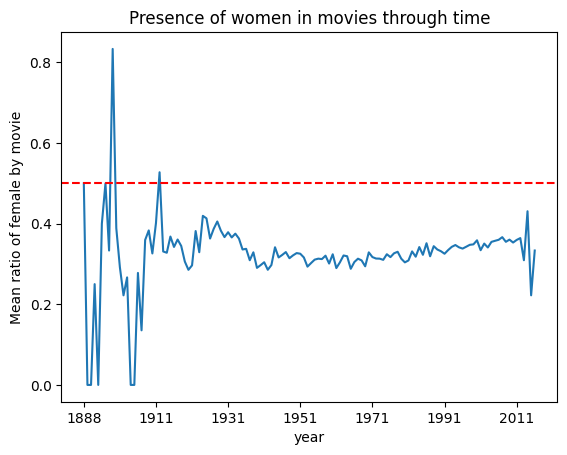

In [44]:
mov_female_gp_year.plot(legend=False)
plt.ylabel('Mean ratio of female by movie')
plt.xlabel('year')
plt.title('Presence of women in movies through time')
plt.axhline(y=0.5,color ='red', ls='--')

/Users/tabtab/.pyenv/versions/3.10.1/lib/python3.10/site-packages/scipy/stats/_resampling.py:118: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den
/Users/tabtab/.pyenv/versions/3.10.1/lib/python3.10/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))
/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_15045/2609639596.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mov_female_gp_year = mov_female_gp_year.mean()


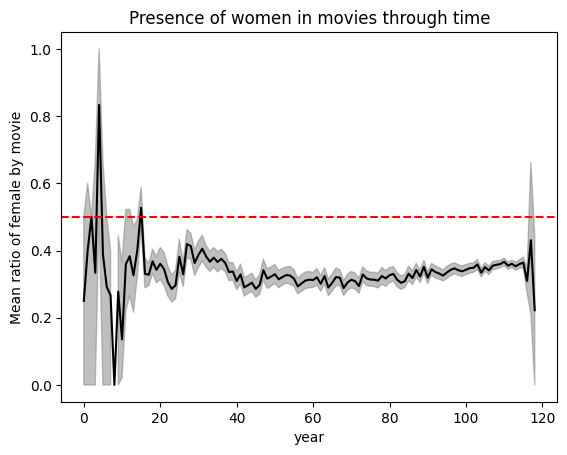

In [45]:
mov_female['movie_release_date'] = mov_female['movie_release_date'].str[:4]   #only take the year
mov_female.sort_values(by = 'movie_release_date', ascending = False).head()

mov_female=mov_female[mov_female.groupby('movie_release_date')['movie_release_date'].transform('count') > 1]
mov_female_gp_year=mov_female.groupby(mov_female['movie_release_date'])[['movie_release_date','female']]

confidence = [[],[]]

for df_idx, df_values in mov_female_gp_year:

  # Bootstrap confidence interval 95% for each month on the mean value
  res = stats.bootstrap((df_values['female'].values,), np.mean, confidence_level=0.95)

  # Get CI difference to mean (necessary as yerr argument for plt.bar)
  confidence[0].append(res.confidence_interval.low)
  confidence[1].append(res.confidence_interval.high)

# Compute monthly average
mov_female_gp_year = mov_female_gp_year.mean()

# Label for regular labelling
x = np.arange(len(mov_female_gp_year.index))

fig, ax = plt.subplots()

plt.fill_between(x, confidence[0],
                 confidence[1], alpha = 0.5, color = 'gray')
plt.plot(x, mov_female_gp_year.female, color='black')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Mean ratio of female by movie')
ax.set_xlabel('year')
ax.set_title('Presence of women in movies through time')
plt.axhline(y=0.5,color ='red', ls='--')

plt.show()



## Correlation ratings/box office revenue

In [46]:
correl = movies_with_bor.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
correl

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55271
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2160
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",7,tt0097499,movie,Henry V,Henry V,1989,137,"Biography,Drama,History",7.5,30177
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",8,tt0058331,movie,Mary Poppins,Mary Poppins,1964,139,"Comedy,Family,Fantasy",7.8,173341
4,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",14,tt0255819,movie,Baby Boy,Baby Boy,2001,130,"Crime,Drama,Romance",6.4,15014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,6740261,/m/0glmbl,Eternally Yours,1939,683131.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/01g6gs"": ""B...",46757,tt0031282,movie,Eternally Yours,Eternally Yours,1939,95,"Comedy,Drama,Romance",5.7,778
7253,54540,/m/0f7hw,Coming to America,1988,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",46765,tt0094898,movie,Coming to America,Coming to America,1988,117,"Comedy,Romance",7.1,208704
7254,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",46776,tt0100666,movie,Spaced Invaders,Spaced Invaders,1990,100,"Adventure,Comedy,Sci-Fi",5.3,3740
7255,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",46780,tt0120202,movie,State and Main,State and Main,2000,105,"Comedy,Drama",6.7,21490


In [47]:
stats.pearsonr(correl['movie_box_off_rev'],correl['averageRating'])

PearsonRResult(statistic=0.16414701775545282, pvalue=5.29468874193649e-45)

In [48]:
# a faire : pourcentage de femme par film + regarder correlation avec les ratings
# treshold 

In [49]:
name_clusters=pd.read_table('Data/MovieSummaries/name.clusters.txt',header=None)#,sep=" ",header=None)
name_clusters.columns=['character_name','freebase_char/actor_map_ID']
name_clusters.head()

,character_name,freebase_char/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [50]:
plot_summaries=pd.read_table('Data/MovieSummaries/plot_summaries.txt',header=None)
plot_summaries.columns=['wiki_movie_ID','movie_plot']
plot_summaries.head()

,wiki_movie_ID,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [51]:
type_char=pd.read_table('Data/MovieSummaries/tvtropes.clusters.txt',header=None)
type_char.columns=['char_type','infos']
type_char.head()

,char_type,infos
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [52]:
import json
list=[]

for i in range(len(type_char)):
    list=list+[json.loads(type_char['infos'][i])]

char_type_df=pd.DataFrame(list)

char_type_df

,char,movie,id,actor
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...
496,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [53]:
char_type_df['char_type']=type_char['char_type']
char_type_df.columns=['character_name','movie_name','freebase_char/actor_map_ID','actor_name','char_type']
char_type_df

,character_name,movie_name,freebase_char/actor_map_ID,actor_name,char_type
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent_minded_professor
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent_minded_professor
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent_minded_professor
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent_minded_professor
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent_minded_professor
...,...,...,...,...,...
496,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,young_gun
497,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,young_gun
498,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,young_gun
499,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,young_gun


In [55]:
correl_corrected = movies_with_corrected_bor.merge(imdb, left_on = 'freebase_movie_ID', right_on = 'freebase_movie_ID')
stats.pearsonr(correl_corrected['movie_box_off_rev'],correl_corrected['averageRating'])

PearsonRResult(statistic=0.16409685318547476, pvalue=0.0)